In [1]:
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingClassifier
import pickle

import shap
import lime

In [2]:
sentinels = ['None', 'n.d.', ' ', '']
df = pd.read_csv('assets/yid_out.tsv', sep='\t', na_values=sentinels)

In [3]:
df.valoreIntero.fillna(df.valoreIntero.mean(), inplace=True)
df.mediaVoto.fillna(df.mediaVoto.mean(), inplace=True)
df.votoDiploma.fillna(round(df.votoDiploma.mean()), inplace=True)


df = df.drop(['luogoDiNascita', 'nazioneNascita'], axis=1)
df = df.astype({'valoreIntero': np.int64, 'votoDiploma': np.int32})
print(df.shape)

(70018, 24)


In [4]:
y = df.Dropout
X = df.drop(['ID_Stud', 'Dropout', 'lastLogin', 'annoAccaCors'], axis = 1)

val = {True: 1, False: 0}
X["sesso"] = X["sesso"].map(val)
X = X.astype({ 'sesso': np.int32})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Training Set shape: {}".format(X_train.shape))
print("Test Set shape: {}".format(X_test.shape))

Training Set shape: (56014, 20)
Test Set shape: (14004, 20)


In [5]:
ohe_elements =  ['cittadinanza', 'facolta', 'tipoIscrizione']
encoder = OneHotEncoder(handle_unknown="ignore")
feature_arr = encoder.fit_transform(X_train[ohe_elements]).toarray()
feature_labels = encoder.get_feature_names_out()
feature_labels = np.array(feature_labels).ravel()
encoded_df = pd.DataFrame(feature_arr, columns=feature_labels)
X_train = X_train.reset_index(drop=True)
X_train = X_train.join(encoded_df)
X_train = X_train.drop(ohe_elements, axis=1)


feature_arr = encoder.transform(X_test[ohe_elements]).toarray()
feature_labels = encoder.get_feature_names_out()
feature_labels = np.array(feature_labels).ravel()
encoded_df = pd.DataFrame(feature_arr, columns=feature_labels)
X_test = X_test.reset_index(drop=True)
X_test = X_test.join(encoded_df)
X_test = X_test.drop(ohe_elements, axis=1)

if "facolta_PSICOLOGIA 1" in X_train.columns:
    X_train = X_train.drop(['facolta_PSICOLOGIA 1'], axis=1)
    X_test = X_test.drop(['facolta_PSICOLOGIA 1'], axis=1)

X_test.head()

,annoCorso,eta,codCorso,creditiTotali,flagIdentificato,primaIscr,sesso,tipoCorso,tipoStudente,ultIscr,...,facolta_MEDICINA E ODONTOIATRIA,facolta_MEDICINA E PSICOLOGIA,"facolta_SCIENZE MATEMATICHE, FISICHE E NATURALI","facolta_SCIENZE POLITICHE, SOCIOLOGIA, COMUNICAZIONE",facolta_SCIENZE STATISTICHE,facolta_SCUOLA DI INGEGNERIA AEROSPAZIALE,tipoIscrizione_FUORI CORSO,tipoIscrizione_IMMATRICOLAZIONE,tipoIscrizione_IN CORSO,tipoIscrizione_RIPETENTE
0,3,27,27630,300,0,8,1,29,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,4,31,15231,120,0,7,1,28,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1,23,30042,180,0,4,0,27,2,1,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2,27,30061,120,1,2,0,28,2,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,5,26,27563,180,1,7,0,27,2,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [6]:
with open('assets/gbdt_model.pickle', 'rb') as f:
    predictor = pickle.load(f)

### Feature importance

In [17]:
mat = pd.DataFrame(zip(X_train.columns.values, predictor.feature_importances_),  columns=['feature', 'importance'])
mat.sort_values(by='importance', inplace=True, ascending=False)

In [18]:
mat.head(10)

,feature,importance
9,ultIscr,0.530623
13,cfuTake,0.227225
3,creditiTotali,0.065688
15,mediaVoto,0.056243
1,eta,0.018118
16,votoDiploma,0.016630
14,ultSup,0.016327
4,flagIdentificato,0.011638
12,ultPren,0.011527
11,cfuPrenotati,0.011173


In [19]:
mat.to_csv('assets/feat_importance.csv')

### SHAP

In [7]:
explainer = shap.TreeExplainer(predictor, feature_perturbation='three_path_dependent')
shap_values = explainer.shap_values(X_test)

In [20]:
# LAVORA SU PROBA NON SU PREDICT
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:100,:], features=X_test.iloc[:100,:])

In [10]:
X_test.rename(columns = {'ultIscr':'lastEnrollment', 'ultSup':'lastPassedExam', 'cfuTake':'creditsEarned', 'ultPren':'lastBookedExam', 'creditiTotali':'totalCredits',
'votoDiploma':'HSDiplomaScore', 'mediaVoto':'avgGrade', 'eta':'age', 'valoreIntero':'income', 'tipoCorso':'programType', 'tipoIscrizione_IN CORSO':'enrollmentType_in time',
'tipoIscrizione_FUORI CORSO':'enrollmentType_out of time', 'cfuPrenotati':'creditsBooked', 'flagIdentificato':'hasPicture', 'facolta_SCUOLA DI INGEGNERIA AEROSPAZIALE':'school_AerospaceEng',
'facolta_ARCHITETTURA':'school_Architecture', 'codCorso':'programCode', 'primaIscr':'firstEnrollment'}, inplace = True)

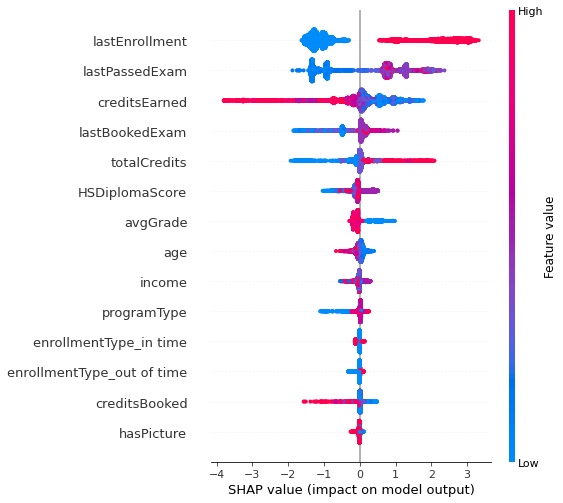

In [11]:
shap.summary_plot(shap_values, features=X_test, max_display=14) #feature_names=fnames, 

In [24]:
X_train = X_train.assign(Dropout=y_train)
X_test = X_test.assign(Dropout=y_test)

In [25]:
X_train.to_csv('assets/xtrain.tsv', index = False, sep='\t')
X_test.to_csv('assets/xtest.tsv', index = False, sep='\t')